# Robot Arm Identification

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Proyecto_Splra')

Mounted at /content/drive


In [2]:
cd SIPPY-master/

/content/drive/MyDrive/Proyecto_Splra/SIPPY-master


In [3]:
!pip install scikit-build
!pip install setuptools_scm
!pip install control -U
!pip install scienceplots
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 860.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 6.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base t

In [4]:
!python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [7]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import sys
sys.path.append('/content/drive/MyDrive/Proyecto_Splra/Python')

from Sparse_Sys_Id import*

import scienceplots
plt.style.use('science')
mpl.rcParams['lines.linewidth'] = 0.6

array([<Axes: >, <Axes: >], dtype=object)

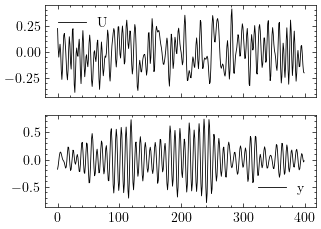

In [10]:
robot_arm= np.loadtxt( '/content/drive/MyDrive/Proyecto_Splra/Data/robot_arm.dat' )
df=pd.DataFrame(robot_arm,columns=['U','y'])
df[:400].plot(subplots=True,color='k')

In [11]:
Time = np.arange(len(df))
dfX,dfU=df[['y']],df[['U']]

ntest=int(0.50*len(dfX))

train,test=dfX[:-ntest],dfX[-ntest:]
Utrain,Utest=dfU[:-ntest],dfU[-ntest:]

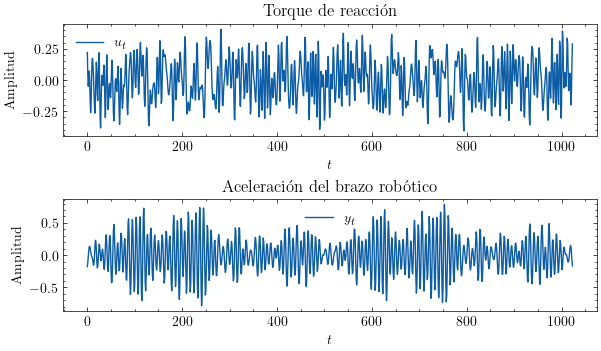

In [12]:
with plt.style.context(['science']):
    fig, axs = plt.subplots(2,1,layout='constrained',figsize=(6, 3.5))
    axs[0].plot(Time, dfU.values,label='$u_t$')
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('Amplitud')
    axs[0].set_title('Torque de reacción')
    axs[0].legend()

    axs[1].plot(Time, dfX.values,label='$y_t$')
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('Amplitud')
    axs[1].set_title('Aceleración del brazo robótico')
    axs[1].legend()

    #fig.savefig('robot_arm_01.jpg', dpi=400)
    plt.show()

In [13]:
signaltonoise(dfX.values, axis=0, ddof=0),signaltonoise(dfU.values, axis=0, ddof=0)

(array([-3.16108997e-10]), array([7.17024747e-10]))

## Lra modeling

In [14]:
from Lra_Modeling import *
from Sparse_Lra import *

In [15]:
wtrain=np.block([[Utrain.values.T],[train.values.T]])
wtest = np.block([[Utest.values.T],[test.values.T]])

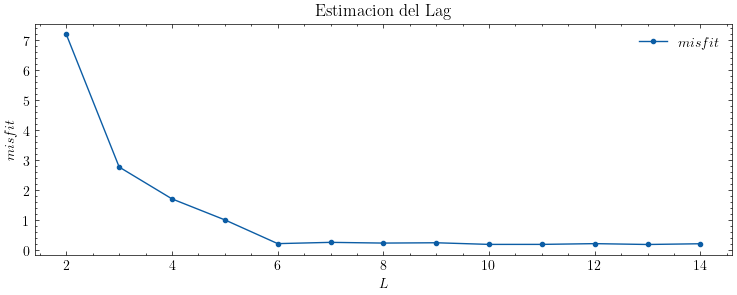

In [16]:
lag_est(wtrain,15,1,1e-2,1e-2)

In [17]:
L=6

In [19]:
M,fit,wh,R_sp,sys_tf,sys_ss,x0= Sparse_lra_sysid(wtrain,L,1,tol=1e-2,delta=1e-2)

In [20]:
M,fit

(0.2199911995674072, 96.98695162880198)

In [21]:
t,y_sim=ctl.forced_response(sys_ss,U=dfU.values.T,X0=x0)

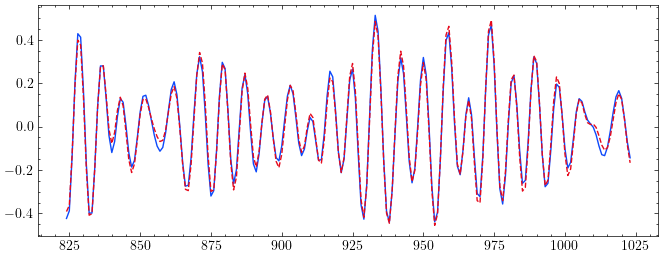

In [22]:
with plt.style.context(['science','high-vis']):
    plt.figure(figsize=(8,3))
    plt.plot(t[-200:],y_sim[-200:])
    plt.plot(t[-200:],dfX[-200:].values)
    plt.show()

In [23]:
1-la.norm(dfX[-ntest:].values.T-y_sim[-ntest:])/la.norm(dfX[-ntest:].values.T-np.mean(dfX[-ntest:].values))

0.9264448064234936

In [24]:
sys_ss

<LinearIOSystem:sys[629]:['u[0]']->['y[0]']>

In [25]:
cnt.zeros(sys_ss)

array([ 0.42766262+0.90154502j,  0.42766262-0.90154502j,
        0.24818745+0.j        ,  0.9719034 +0.19908988j,
        0.9719034 -0.19908988j, -9.15141626+0.j        ])

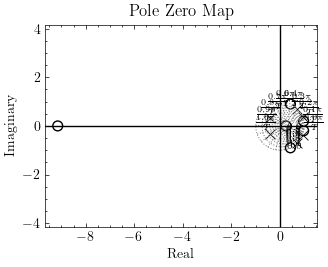

In [26]:
cnt.pzmap(sys_ss,grid=True)
plt.show()

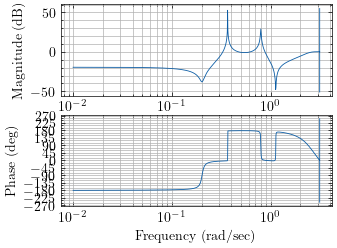

In [ ]:
cnt.bode(sys_tf)
plt.show()

In [27]:
sparsity(np.asarray(sys_tf.num)) + sparsity(np.asarray(sys_tf.den))

200.0

In [28]:
100-sparsity(np.block([[sys_ss.A,sys_ss.B],[sys_ss.C,sys_ss.D]]))

61.224489795918366

In [29]:
sys_tf

TransferFunction(array([-0.05119331, -0.31248894,  1.20560668, -1.84348805,  1.63918771,
       -0.76958152,  0.11394585]), array([ 1.        , -2.41906663,  2.12844835, -0.2860305 , -0.46373522,
       -0.06607382,  0.27548996]), 1)

## Sippy Arx

In [30]:
from sippy import *
from sippy import functionsetSIM as fsetSIM

In [31]:
sys_arx= system_identification(train.values, Utrain.values,'ARX',ARX_orders=[6,6,0])

In [32]:
t,y_arx = ctl.forced_response(sys_arx.G, U=dfU.values.T)

In [33]:
y_arx.shape

(1024,)

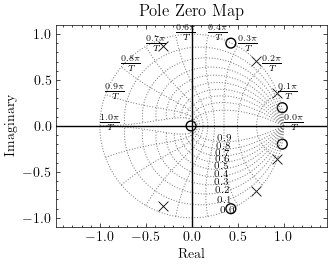

In [34]:
cnt.pzmap(sys_arx.G,grid=True)
plt.show()

In [35]:
1-(la.norm(signal.detrend(train.values.T)-y_arx[:-ntest])/(la.norm(train.values-np.mean(train.values))))

0.8527093817245152

In [36]:
1-(la.norm(test.values.T-y_arx[-ntest:])/(la.norm(test.values-np.mean(test.values))))

0.9403131857400808

In [37]:
sparsity(np.asarray(sys_arx.NUMERATOR)) + sparsity(np.asarray(sys_arx.DENOMINATOR))

200.0

## Sippy N4sid

In [38]:
sys_n4sid= system_identification(train.values, Utrain.values,'N4SID',SS_fixed_order = 6)

In [39]:
sys_n4sid_ss=ctl.ss(sys_n4sid.A,sys_n4sid.B,sys_n4sid.C,sys_n4sid.D,1)

In [40]:
t,y_n4sid = ctl.forced_response(sys_n4sid_ss, U=dfU.values.T)

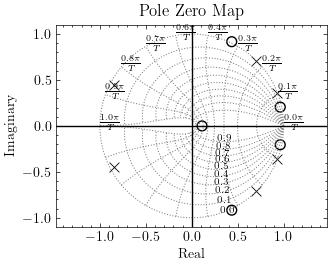

In [ ]:
cnt.pzmap(sys_n4sid_ss,grid=True)
plt.show()

In [41]:
1-(la.norm(signal.detrend(train.values.T)-y_n4sid[:-ntest])/(la.norm(train.values-np.mean(train.values))))

0.8155861987722481

In [42]:
1-(la.norm(test.values.T-y_n4sid[-ntest:])/(la.norm(test.values-np.mean(test.values))))

0.9147559514505884

In [43]:
100-sparsity(np.block([[sys_n4sid_ss.A,sys_n4sid_ss.B],[sys_n4sid_ss.C,sys_n4sid_ss.D]]))

2.040816326530617